In [1]:
import cantera as ct
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# Unit conversions
psi2Pa = 6894.76

In [27]:
# setpoints of engine
OF = 2.1

#mass flow rates [kg/s]
mdot_total = 9 
mdot_lox = mdot_total * (OF/(OF+1))
mdot_kero = mdot_total * (1 / (OF + 1))

# Propellant Temps [K]
T_lox = 90 
T_kero = 2980
T_amb = 298

T_mean = T_lox * (OF/(OF+1)) + T_kero * (1/(OF+1))

#pressures [Pa]
P_chamber = 500 * psi2Pa 
P_amb = 14.7 * psi2Pa

In [28]:
# Jet-A reaction mechanism

#mixed inlet
Y_mix = {"POSF10325": (1/(OF+1)), "O2": (OF/(OF+1))}
inlet = ct.Solution("A2NTC_skeletal.yaml")
inlet.TPY = T_mean, P_chamber, Y_mix

# arbitrary exhaust 
exhaust = ct.Solution("A2NTC_skeletal.yaml")
exhaust.TP = T_amb, P_amb

In [45]:
# lox & kero res --(mass flow controllers)-> mixer -> chamber --(Pressure Reg)-> outlet 

# reservoirs (inlet and outlet)
res_inlet = ct.Reservoir(inlet, name="Inlet", clone=True)
res_outlet = ct.Reservoir(exhaust, name="Outlet", clone=True)

# reactor 
rctr_chamber = ct.IdealGasReactor(inlet, name="Chamber", clone=True,  energy='off')

# mass flow controller (reservoir -> reactor)
mfc_inlet = ct.MassFlowController(upstream= res_inlet, downstream= rctr_chamber, mdot=lambda t:mdot_total, name="Propellant Mass Flow Controller") #lox res to mixer

#pressure controllers (outlet)
pc_outlet = ct.PressureController(upstream=rctr_chamber, downstream=res_outlet, primary=mfc_inlet, K=1e-5)

sim = ct.ReactorNet([rctr_chamber])


In [46]:
# Create a SolutionArray to store the data
time_history = ct.SolutionArray(exhaust, extra=["t"])

# Set the maximum simulation time
max_simulation_time = 500  # seconds

# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < max_simulation_time:
    t = sim.step()

    # We will store only every 10th value.
    if counter % 10 == 0:
        # Extract the state of the reactor
        time_history.append(rctr_chamber.phase.state, t=t)

    counter += 1

# Stop the stopwatch
toc = time.time()

print(f"Simulation Took {toc-tic:3.2f}s to compute, with {counter} steps")

Simulation Took 0.08s to compute, with 4028 steps


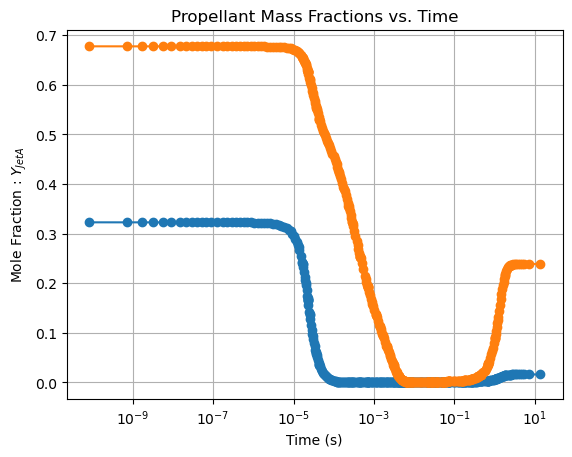

,t,T,density,Y_POSF10325,Y_C2H4,Y_CH4,Y_C3H6,Y_iC4H8,Y_C4H81,Y_H2,...,Y_C6H5O,Y_C6H5CO,Y_C6H5CHO,Y_A2C11H21,Y_A2C11H21O2,Y_A2C11H20OOH,Y_A2C11H20,Y_A2C11H21O4,Y_A2C11H20O3,Y_N2
0,8.295102e-11,1022.258065,17.436526,0.322581,4.081964e-11,1.652975e-13,2.877779e-11,4.081955e-12,1.224585e-11,1.054203e-14,...,1.472910e-26,1.815760e-39,4.759576e-30,7.981011e-09,3.647618e-12,4.977482e-14,2.938499e-17,5.620199e-18,1.917216e-16,0.0
1,7.407030e-10,1022.258065,17.436526,0.322581,4.364692e-10,1.312580e-11,3.077102e-10,4.364682e-11,1.309402e-10,7.876679e-13,...,3.145743e-23,7.703506e-35,3.023976e-26,7.093428e-08,2.638934e-10,2.864498e-11,1.311603e-13,3.298233e-15,8.758223e-13,0.0
2,1.695625e-09,1022.258065,17.436526,0.322580,1.236574e-09,6.849259e-11,8.717828e-10,1.236571e-10,3.709707e-10,3.821626e-12,...,8.775693e-22,5.422840e-33,9.973624e-25,1.612768e-07,1.222567e-09,2.854151e-10,3.081519e-12,3.291291e-14,2.061749e-11,0.0
3,3.245361e-09,1022.258065,17.436526,0.322580,3.095342e-09,2.491673e-10,2.182211e-09,3.095335e-10,9.285989e-10,1.274684e-11,...,1.678435e-20,1.679130e-31,1.712303e-23,3.052533e-07,3.796892e-09,1.522655e-09,3.308032e-11,1.756828e-13,2.214861e-10,0.0
4,5.513992e-09,1022.258065,17.436526,0.322580,7.038343e-09,7.120216e-10,4.962020e-09,7.038326e-10,2.111494e-09,3.354854e-11,...,2.850044e-19,2.997192e-30,1.881133e-22,5.103117e-07,9.076804e-09,5.275674e-09,2.068354e-10,6.088477e-13,1.385221e-09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,4.203993e+00,1022.258065,0.318387,0.015903,3.676340e-02,1.630831e-02,1.237599e-02,1.836687e-03,5.558762e-03,2.001655e-03,...,2.920596e-03,1.360024e-08,2.421755e-03,8.041546e-07,1.002870e-09,1.903105e-09,8.764146e-04,1.413087e-15,1.921729e-08,0.0
398,4.724773e+00,1022.258065,0.318378,0.015903,3.676402e-02,1.630826e-02,1.237627e-02,1.836735e-03,5.558927e-03,2.001639e-03,...,2.920648e-03,1.360013e-08,2.421806e-03,8.041758e-07,1.002893e-09,1.903147e-09,8.764213e-04,1.413112e-15,1.921764e-08,0.0
399,5.486123e+00,1022.258065,0.318377,0.015904,3.676414e-02,1.630825e-02,1.237632e-02,1.836744e-03,5.558957e-03,2.001636e-03,...,2.920658e-03,1.360012e-08,2.421816e-03,8.041798e-07,1.002897e-09,1.903155e-09,8.764225e-04,1.413117e-15,1.921771e-08,0.0
400,7.067174e+00,1022.258065,0.318377,0.015904,3.676414e-02,1.630825e-02,1.237632e-02,1.836745e-03,5.558960e-03,2.001636e-03,...,2.920658e-03,1.360011e-08,2.421817e-03,8.041801e-07,1.002897e-09,1.903156e-09,8.764226e-04,1.413118e-15,1.921771e-08,0.0


In [52]:
df = time_history.to_pandas()
plt.figure()
plt.semilogx(time_history.t, time_history.POSF10325, "-o", time_history.t, time_history.O2, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Mole Fraction : $Y_{Jet A}$")
plt.title("Propellant Mass Fractions vs. Time")
plt.grid(True)
plt.show()
df